# Building a logistic regression model

In this notebook, I'm building a [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) model to predict which subreddit a post came from based on its title. I'll rely on `CountVectorizer` to do this. The benefit to building a logistic regression model is that we'll have interpretable results, meaning we can decipher which title words seem to be most indicative of the subreddit they came from.

## Importing Libraries

In [15]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

## Loading the data

In [2]:
filepath = '../data/clean_1587672956.csv'
df = pd.read_csv(filepath)

In [3]:
df.head()

,subreddit,subreddit_subscribers,title,selftext,score,num_comments,author,created_utc
0,Christianity,233423,Christian and wondering if God provides what w...,"Please forgive me for sounding so flippant, bu...",1,0,friendlyhello123,1587672956
1,Christianity,233423,What do you think is often ignored in the bibl...,Like genealogies for example... both Rahab and...,1,0,Clear-Plastic,1587671298
2,Christianity,233422,How do you deal with some new member suddenly ...,Have this issue now. This member somehow becam...,1,0,akhil_gs,1587671035
3,Christianity,233423,"Ran Across a Great Podcast about Christianity,...","Hi all, \n\nI ran across this podcast where a ...",1,0,MrNewDenver,1587670810
4,Christianity,233423,Desire for wealth,Hi-\nI have been thinking about it a bit latel...,1,0,FloppingGazelle,1587670685


In [4]:
df.shape

(28735, 8)

## Train/test split

In [5]:
X = df['title']
y = df['subreddit'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

## Creating a pipeline and grid searching

In [6]:
# Create pipeline object with CountVectorizer and LogisticRegression
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression(solver='liblinear', max_iter=1000))
])

# Create paramater grid to search over
pipe_params = {
    'cvec__max_df': [0.4, 0.6, 0.8],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'logreg__C': [0.01, 0.1, 1],
    'logreg__penalty': ['l1', 'l2'],
}

In [7]:
# Create grid search with pipeline and paramaters
gs = GridSearchCV(pipe,
                  pipe_params,
                  cv=5)

# Fit on training data
gs.fit(X_train, y_train);

In [8]:
# See what parameters the grid search settled on
print(gs.best_params_)

{'cvec__max_df': 0.4, 'cvec__ngram_range': (1, 2), 'logreg__C': 0.1, 'logreg__penalty': 'l2'}


In [9]:
# View training score, test score, and baseline accuracy
print('Train score:', round(gs.score(X_train, y_train), 4))
print('Test score:', round(gs.score(X_test, y_test), 4))
print('Baseline accuracy:', round(y.value_counts(normalize=True)[0], 4))

Train score: 0.8699
Test score: 0.7487
Baseline accuracy: 0.5234


Overall, a 75% accuracy score is not too bad, especially considering that */r/Catholicism* is essentially a subset of */r/Christianity*. I'm a little disappointed that the model looks to be substantially overfitting, but no degree of regularization seems to help.

## Which words and phrases tended to be most predictive?

In [10]:
# Get words used in the model
words = gs.best_estimator_.named_steps['cvec'].get_feature_names()

# Get associated coefficients of words used
coefficients = gs.best_estimator_.named_steps['logreg'].coef_

# Create data frame out of words and their coefficients
coef_df = pd.DataFrame({
    'features': words,
    'coefs': coefficients[0]
})

In [11]:
# Get words most predictive of /r/Catholicism
coef_df.sort_values('coefs').head(20)

,features,coefs
15581,catholic,-2.153277
50915,mass,-2.063608
16063,catholicism,-1.704409
70273,rosary,-1.584607
19855,confession,-1.543783
80085,the church,-1.440948
16155,catholics,-1.413196
76291,st,-1.320548
64043,pope,-1.243571
70730,saint,-1.033621


In [12]:
# Get words most predictive of /r/Christianity
coef_df.sort_values('coefs').tail(20)

,features,coefs
21330,covid,0.519496
71222,saved,0.522568
23189,denomination,0.528118
84465,to church,0.529836
63633,please,0.539434
30105,fear,0.553230
23220,denominations,0.569211
47957,lgbt,0.570547
61609,pandemic,0.593808
17210,christ,0.602729


Looking at the word coefficients, we can see that the words most predictive of */r/Catholicism* are much stronger than those most predictive of */r/Christianity*. They are words deeply related to Catholic theology like "mass", "rosary", and "confession".

## What was our model most likely to get wrong?

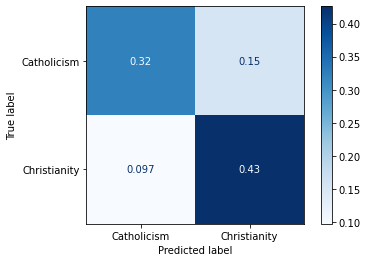

In [19]:
plot_confusion_matrix(gs.best_estimator_, X_test, y_test, normalize='all', cmap='Blues');

There are more posts misclassified as being from */r/Christianity* than */r/Catholicism*. Our model is probably very good at correctly predicting */r/Catholicism* posts when they contain words strongly associated with Catholicism (like "pope"), but not so great when they contain only generically Christian words (like "jesus").

## Which posts did our model get wrong?

In [ ]:
# Make df columns easier to read
pd.options.display.max_colwidth = 140

In [ ]:
# Create dataframe of title, actual subreddit, and predicted subreddit
test_df = pd.DataFrame({
    'title': X_test,
    'actual': y_test,
    'predicted': gs.best_estimator_.predict(X_test)
})

In [ ]:
# Get posts incorrectly predicted as being from /r/Christianity
predicted_christianity = test_df['predicted'] == 'Christianity'
actual_catholicism = test_df['actual'] == 'Catholicism'
test_df[predicted_christianity & actual_catholicism].head(10)

In [ ]:
# Get posts incorrectly predicted as being from /r/Catholicism
predicted_catholicism = test_df['predicted'] == 'Catholicism'
actual_christianity = test_df['actual'] == 'Christianity'
test_df[predicted_catholicism & actual_christianity].head(10)

Looking at some of the posts misclassified by our model, I'm not sure a human interpreter could have done any better. Posts entitle "I'm afraid" and "What is the difference" are simply too vague to make any sense of. There are some intersting misses, however, like "His Holiness received a new Popemobile this week". The reference to the Pope seems to be a dead giveaway that the post comes from */r/Catholicism*, but the model is unable to pick up on the reference because the actual phrase used is "Popemobile".